# **Práctica 3 : Análisis de Señales ECG**



*   Antonia Yepes Quintero - 1036960061
*   Isabella Bedoya Orozco - 1001013873



In [24]:
import numpy as np
import scipy.io as sio
from scipy.signal import find_peaks
import scipy.stats as st
from scipy.stats import kstest, norm, levene, ttest_ind, mannwhitneyu
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
data = sio.loadmat ('/content/drive/MyDrive/Colab Notebooks/signals.mat')
print(data.keys())
ecg_filtrada = data['ECG_filtered'].flatten()
ecg_cruda = data['ECG_asRecording'].flatten()
print(ecg_filtrada.shape)

dict_keys(['__header__', '__version__', '__globals__', 'Fs', 'ECG_asRecording', 'ECG_filtered', 'EMG_filtered1', 'EMG_filtered2', 'EMG_asRecording1', 'EMG_asRecording2'])
(30720,)


La función RMS permite calcular el valor cuadrático medio de una señal y se define en forma discreta con N número de muestras como:

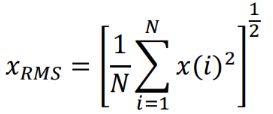


Creación de la función RMS:

In [26]:
def calcular_rms(signal):
  N = len(signal)
  valor_rms = np.sqrt(np.sum(signal**2)/N)
  return valor_rms

Se crea el vector de tiempo para ambas señales:

In [27]:
Fs = 1024  # Frecuencia de muestreo en Hz
T = 1 / Fs
muestras = (ecg_cruda.size)
t = np.arange(0,muestras*T, T)
print(t)

[0.00000000e+00 9.76562500e-04 1.95312500e-03 ... 2.99970703e+01
 2.99980469e+01 2.99990234e+01]


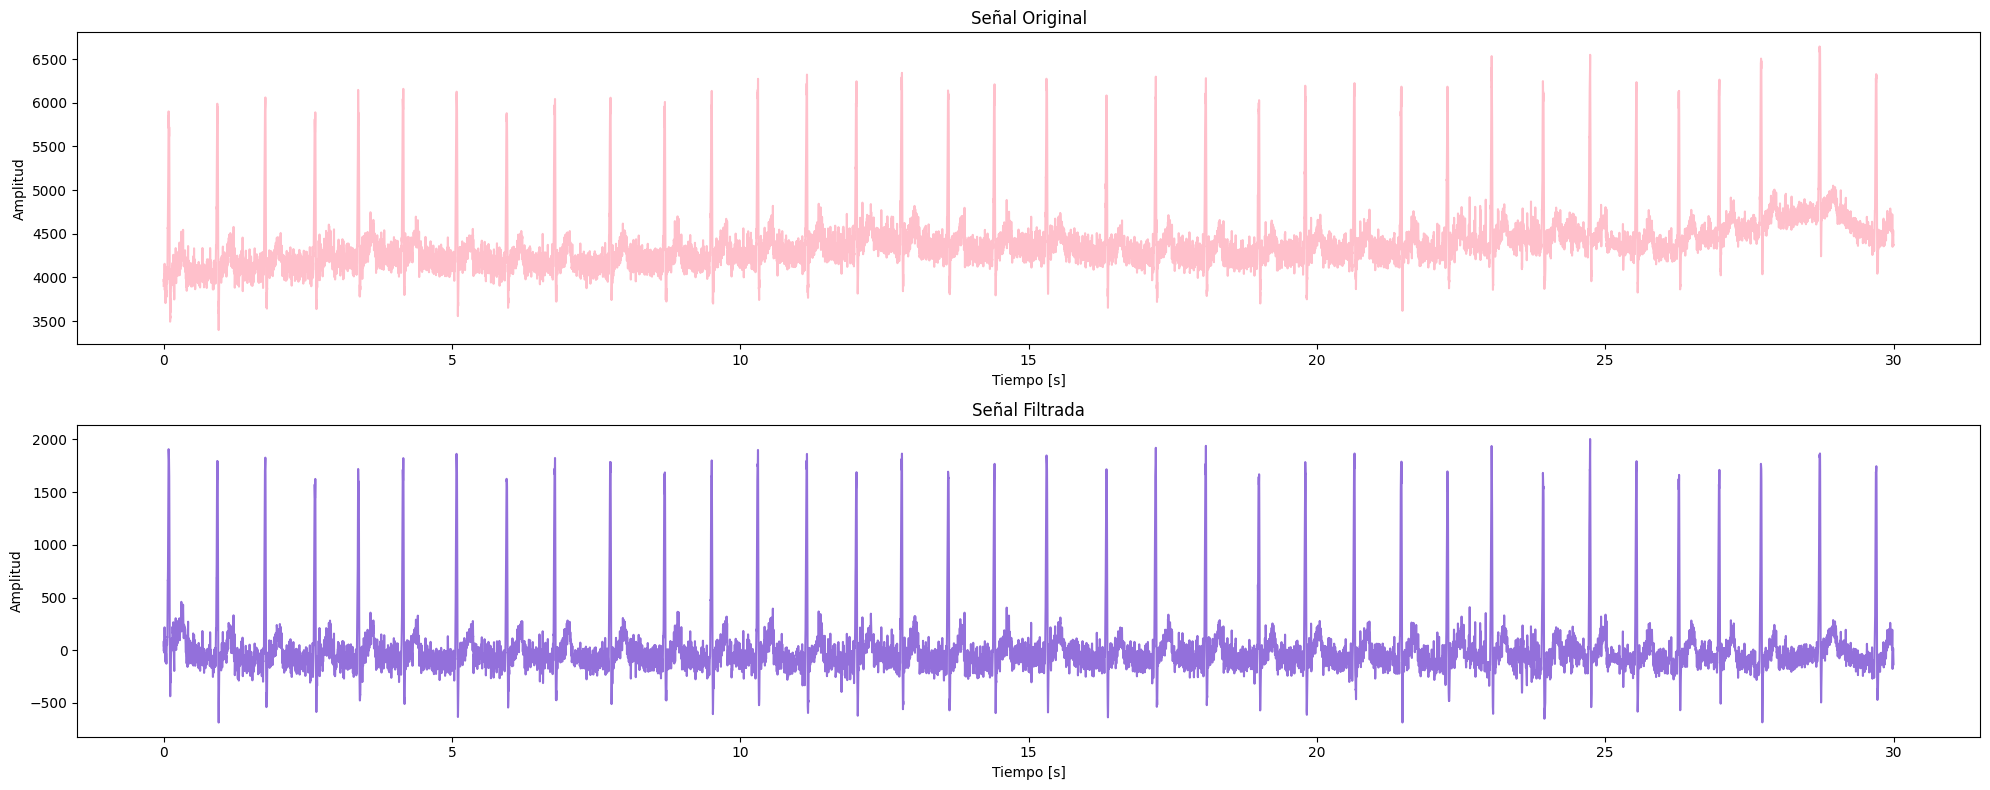

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20,8))
plt.subplot(2, 1, 1)
plt.plot(t,ecg_cruda, color = 'pink')
plt.title('Señal Original')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')

plt.subplot(2, 1, 2)
plt.plot(t,ecg_filtrada, color = 'mediumpurple')
plt.title('Señal Filtrada')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.tight_layout()
plt.show()


**Observaciones:**
La señal original presenta un alto nivel de ruido, con oscilaciones adicionales a las respectivas del latido del corazón, además de un desplazamiento centrado alrededor de los 4000. Este ruido podría estar relacionado con el ruido electromiográfico (EMG), que tiene su origen en la actividad muscular y se solapa con las señales del ECG. Según el estudio de MDPI, el ruido generado por los músculos se encuentra típicamente en el rango de 20 a 500 Hz, lo que puede interferir con la correcta interpretación de los picos del ECG [1].

La señal filtrada muestra una notable reducción de este ruido y está centrada en 0, lo que indica que el filtro aplicado ha corregido el desplazamiento de base (offset). Dado que las señales cardíacas relevantes para el ECG se encuentran en el rango de 0.5 a 50 Hz, es probable que se haya utilizado un filtro pasa-bajo o pasa-banda, diseñado para conservar las frecuencias correspondientes a la actividad cardíaca, mientras reduce tanto el ruido de alta frecuencia como el desplazamiento de base. Los picos de los latidos del corazón permanecen en la señal filtrada, lo que sugiere que el filtro ha eliminado las componentes no deseadas sin comprometer los datos del ECG.

Graficación de un ciclo cardiaco de la señal original:

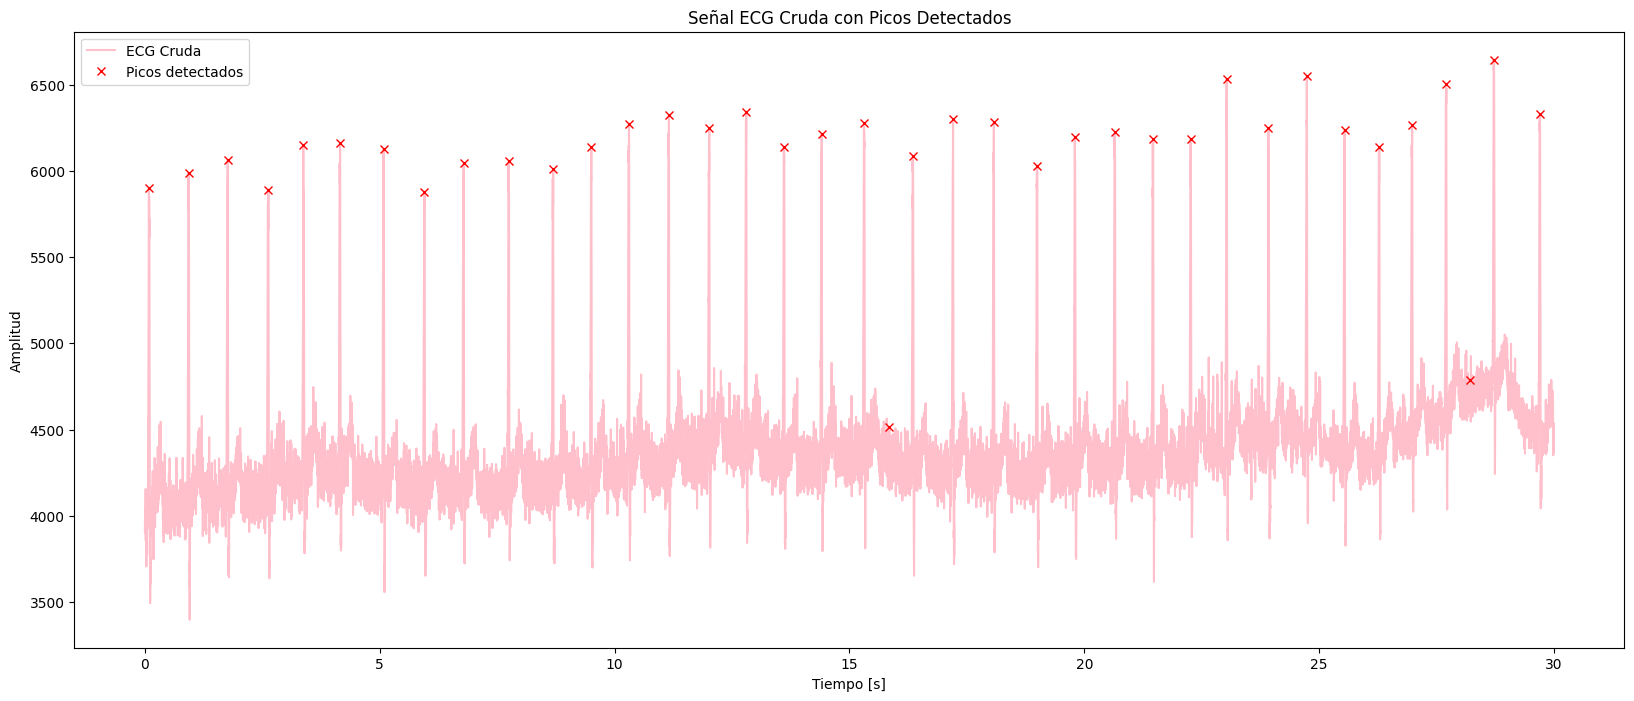

In [29]:
peaks, _ = find_peaks(ecg_cruda, distance=Fs/2, height=0)
plt.figure(figsize=(20, 8))
plt.plot(t, ecg_cruda, label='ECG Cruda', color='pink')
plt.plot(t[peaks], ecg_cruda[peaks], 'rx', label='Picos detectados')
plt.title('Señal ECG Cruda con Picos Detectados')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.legend()
plt.show()

Text(0, 0.5, 'Amplitud')

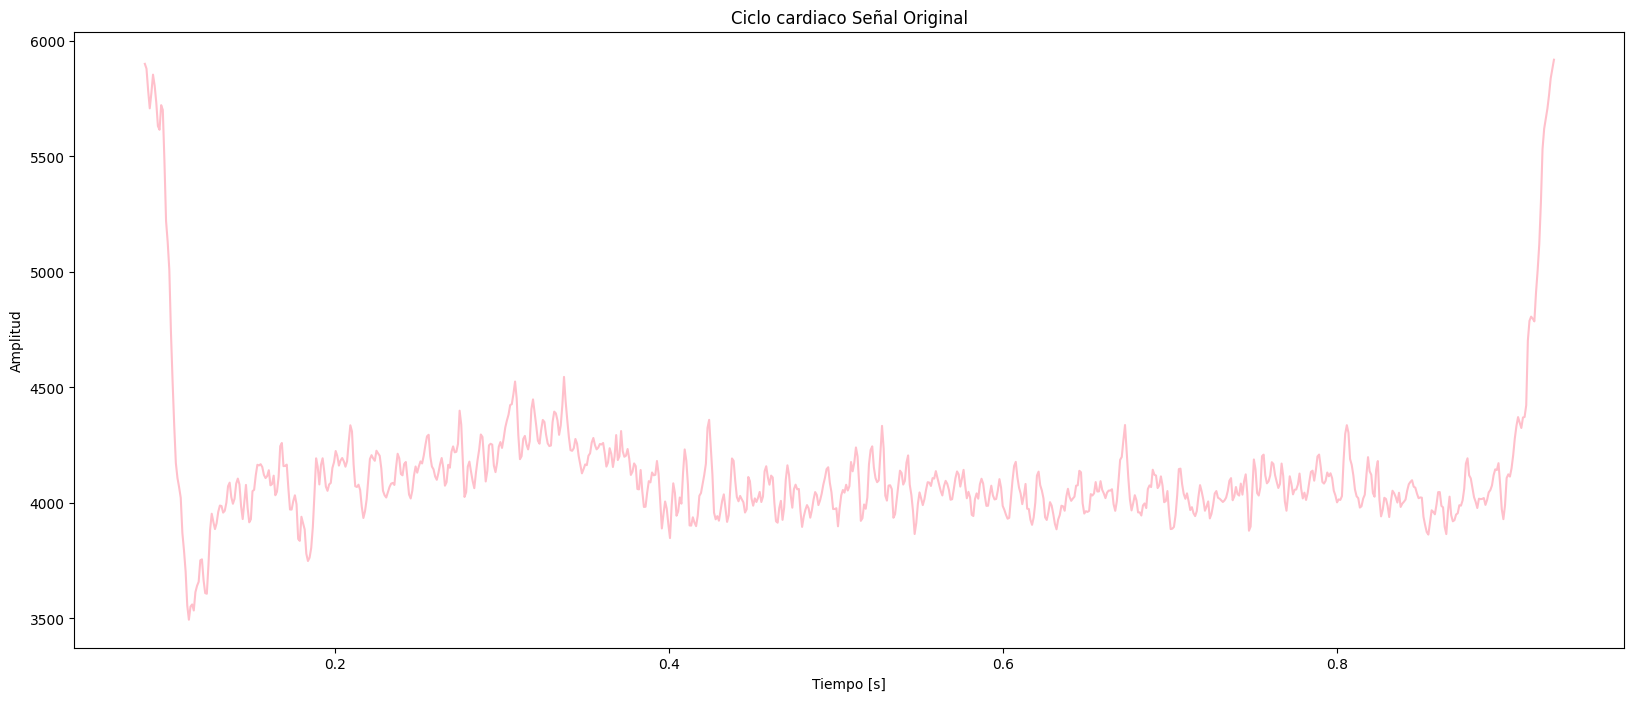

In [30]:
t_ciclo = t[peaks[0]:peaks[1]]
ciclo_cruda = ecg_cruda[peaks[0]:peaks[1]]
plt.figure(figsize=(20, 8))
plt.plot(t_ciclo, ciclo_cruda, color = 'pink')
plt.title('Ciclo cardiaco Señal Original')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')

Estadísticas:

In [31]:
# Calcular promedio
promedio_crudo = np.mean(ciclo_cruda)
print("El promedio de la señal original es: ", promedio_crudo)

# Calcular RMS
RMS_cruda = calcular_rms(ciclo_cruda)
print("El RMS de la señal original es: ", RMS_cruda)

# Calcular la Varianza
varianza_cruda = np.var(ciclo_cruda)
print("La varianza de la señal original es: ", varianza_cruda)

# Calcular Desviación estándar
desviacion_estandar_cruda = np.std(ciclo_cruda)
print("La desviación estándar de la señal original es: ", desviacion_estandar_cruda)



El promedio de la señal original es:  4131.136266878161
El RMS de la señal original es:  4142.454957820607
La varianza de la señal original es:  93646.2220564969
La desviación estándar de la señal original es:  306.01670225086883


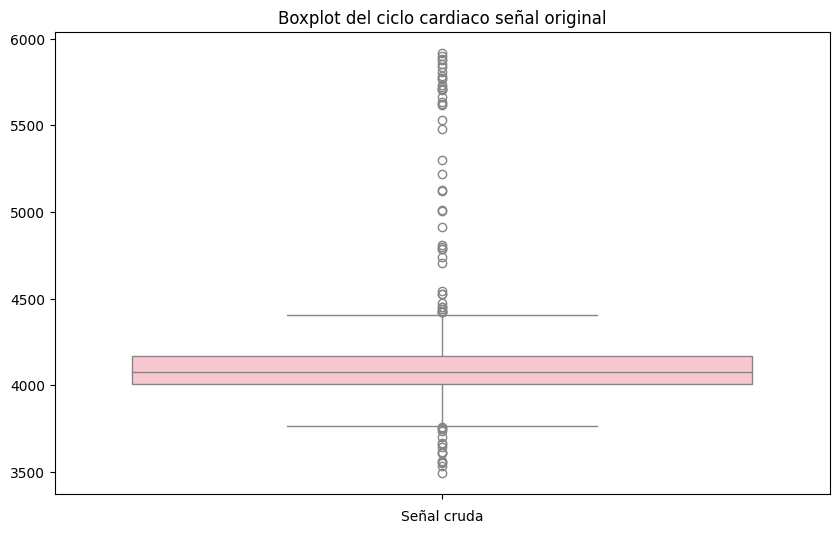

In [32]:
# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(ciclo_cruda, color='pink')
plt.title('Boxplot del ciclo cardiaco señal original')
plt.xlabel('Señal cruda')
plt.show()

**Analisis de los resultados:**

* La mayor parte de los valores de amplitud están agrupados alrededor del promedio 4131. Esto sugiere que hay un desplazamiento de base o offset en la señal, ya que no está centrada en cero [2].
* La proximidad entre el promedio 4131 y el valor RMS 4142 indica que la señal está relativamente estable, con pequeñas fluctuaciones en torno al valor promedio.
*  La alta varianza 93646.22 refleja la dispersión significativa en la señal, influenciada por los picos altos de los latidos (complejos QRS en un ECG típico) y las zonas más bajas (segmentos PR y ST entre los latidos). Este comportamiento es común en las señales de ECG debido a la naturaleza de los ciclos cardíacos [3].
*  La desviación estándar de 306.01 indica una gran variabilidad, lo cual es coherente con la visualización del boxplot, que muestra varios valores atípicos. Esto también sugiere fluctuaciones notables en la señal, causadas por los picos relacionados con los latidos y posiblemente influenciados por ruido o artefactos.

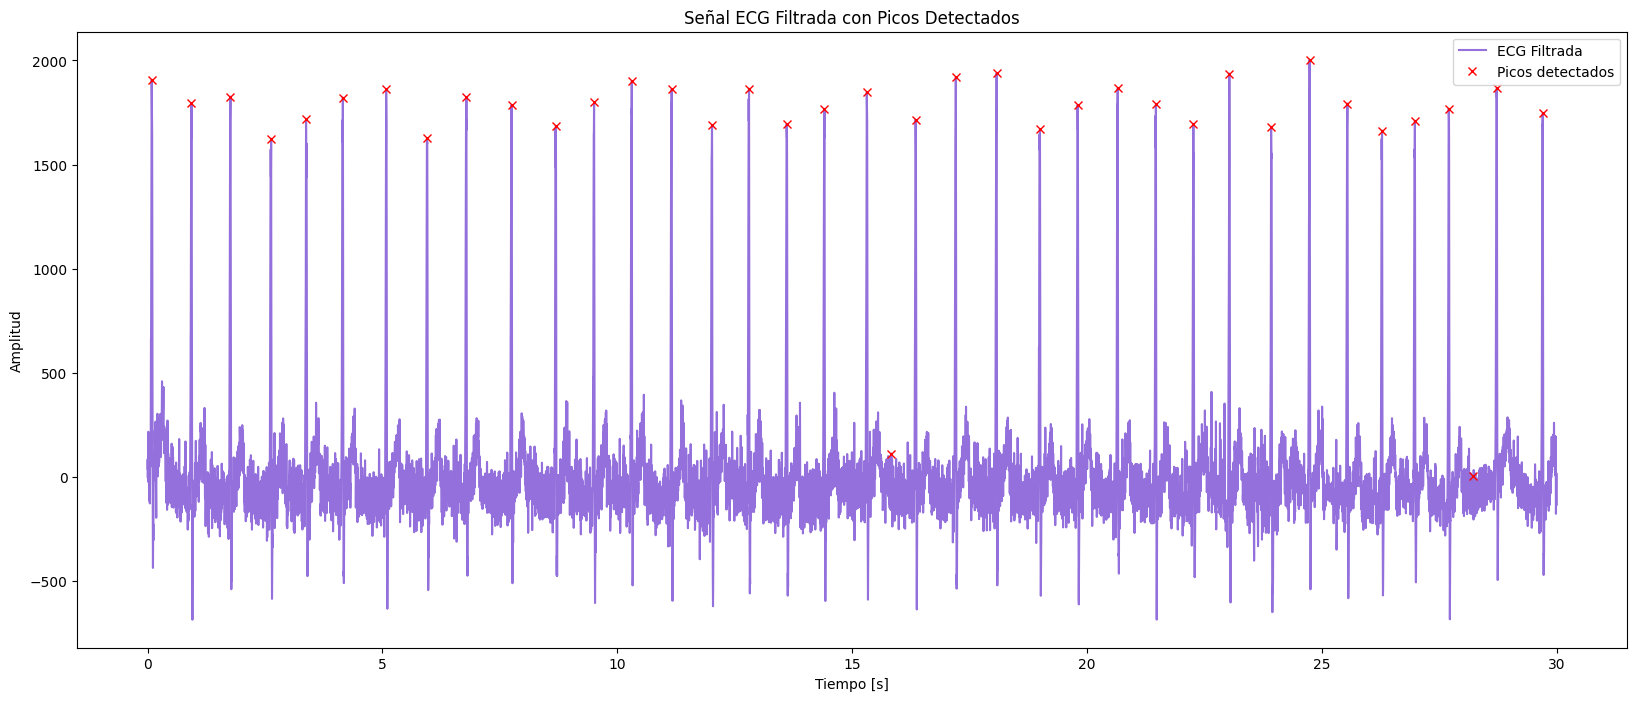

In [33]:
peaks, _ = find_peaks(ecg_filtrada, distance=Fs/2, height=0)
plt.figure(figsize=(20, 8))
plt.plot(t, ecg_filtrada, label='ECG Filtrada', color='mediumpurple')
plt.plot(t[peaks], ecg_filtrada[peaks], 'rx', label='Picos detectados')
plt.title('Señal ECG Filtrada con Picos Detectados')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.legend()
plt.show()

Text(0, 0.5, 'Amplitud')

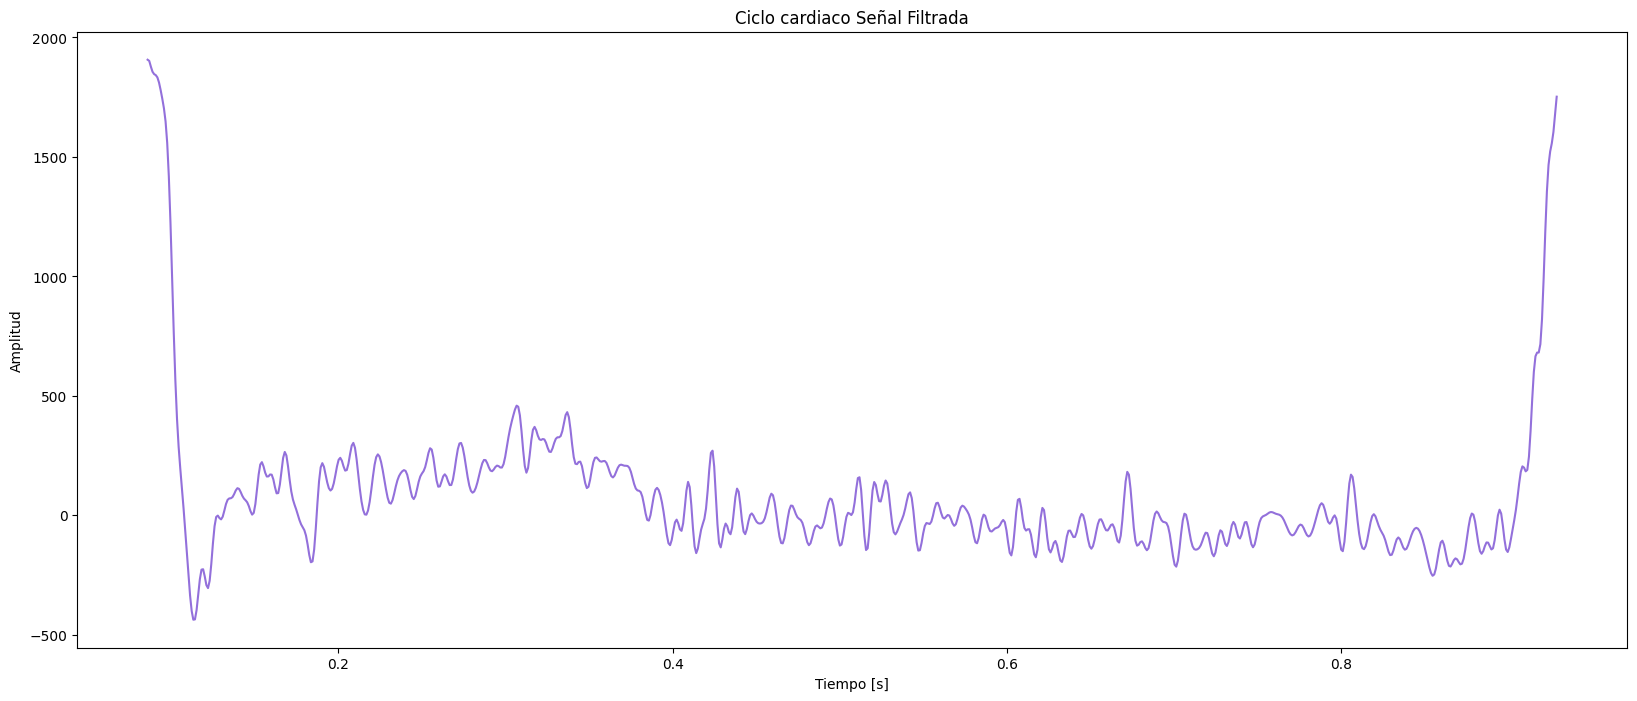

In [34]:
t_ciclo = t[peaks[0]:peaks[1]]
ciclo_filtrada = ecg_filtrada[peaks[0]:peaks[1]]
plt.figure(figsize=(20, 8))
plt.plot(t_ciclo, ciclo_filtrada, color = 'mediumpurple')
plt.title('Ciclo cardiaco Señal Filtrada')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')

In [35]:
# Calcular promedio
promedio_filtrado = np.mean(ciclo_filtrada)
print("El promedio de la señal filtrada es: ", promedio_filtrado)

# Calcular RMS
RMS_filtrada = calcular_rms(ciclo_filtrada)
print("El RMS de la señal filtrada es: ", RMS_filtrada)

# Calcular la Varianza
varianza_filtrada = np.var(ciclo_filtrada)
print("La varianza de la señal filtrada es: ", varianza_filtrada)

# Calcular Desviación estándar
desviacion_estandar_filtrada = np.std(ciclo_filtrada)
print("La desviación estándar de la señal filtrada es: ", desviacion_estandar_filtrada)


El promedio de la señal filtrada es:  74.00995782055861
El RMS de la señal filtrada es:  319.62757818893766
La varianza de la señal filtrada es:  96684.31488232457
La desviación estándar de la señal filtrada es:  310.94101511753735


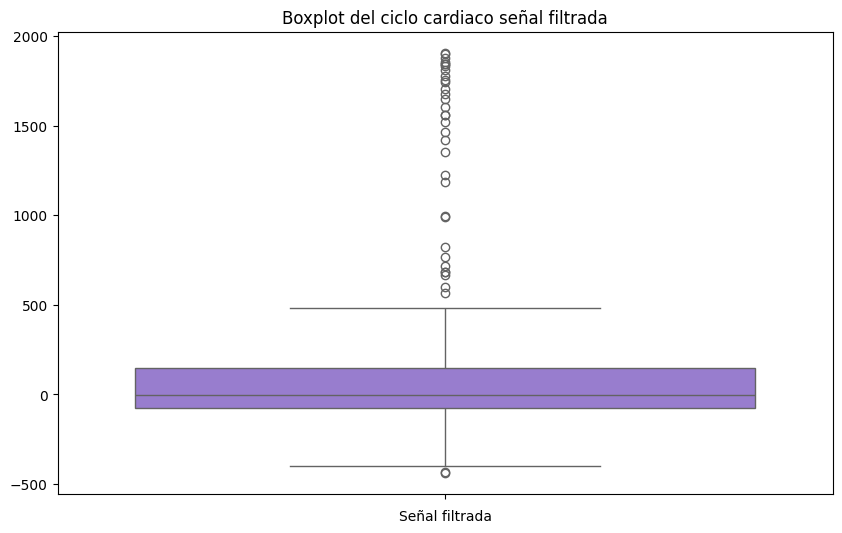

In [36]:
# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(ciclo_filtrada, color='mediumpurple')
plt.title('Boxplot del ciclo cardiaco señal filtrada')
plt.xlabel('Señal filtrada')
plt.show()

**Análisis de los resultados:**

* El promedio ahora es 74.00, lo que muestra que el filtrado ha corregido ese desplazamiento y ha centrado la señal en torno a cero.

* El RMS en la señal filtrada es 319.63, lo que indica una reducción significativa en la variabilidad de la señal. Esto se debe a que el proceso de filtrado ha eliminado componentes no deseados (como el ruido o las variaciones de baja frecuencia), lo que resulta en una señal más "limpia" y con menos fluctuaciones abruptas no relacionadas con el comportamiento fisiológico de los latidos del corazón. Esto puede indicar que la señal ahora está más concentrada en torno a valores de amplitud más pequeños y que las fluctuaciones más extremas (incluyendo posibles artefactos) han sido suavizadas.

* La pequeña diferencia en la varianza entre la señal original y la filtrada puede deberse a que el filtrado ha eliminado el ruido de baja frecuencia, pero ha conservado o incluso resaltado algunas fluctuaciones fisiológicas importantes, como los complejos QRS del ciclo cardíaco. Aunque en general esperábamos una reducción en la varianza, este valor sugiere que la filtración permitió la conservación de los eventos significativos.

* Después del filtrado, la desviación estándar es 310.94, un valor ligeramente superior. Esto indica que, si bien el filtrado ha eliminado ciertos componentes de baja frecuencia no deseados, la señal aún conserva variaciones significativas relacionadas con los eventos fisiológicos importantes, como los picos de los latidos del corazón. Estos picos representan variaciones bruscas en la amplitud, que podrían haber contribuido al aumento en la desviación estándar.

Extracción de 15 ciclos para la señal filtrada:

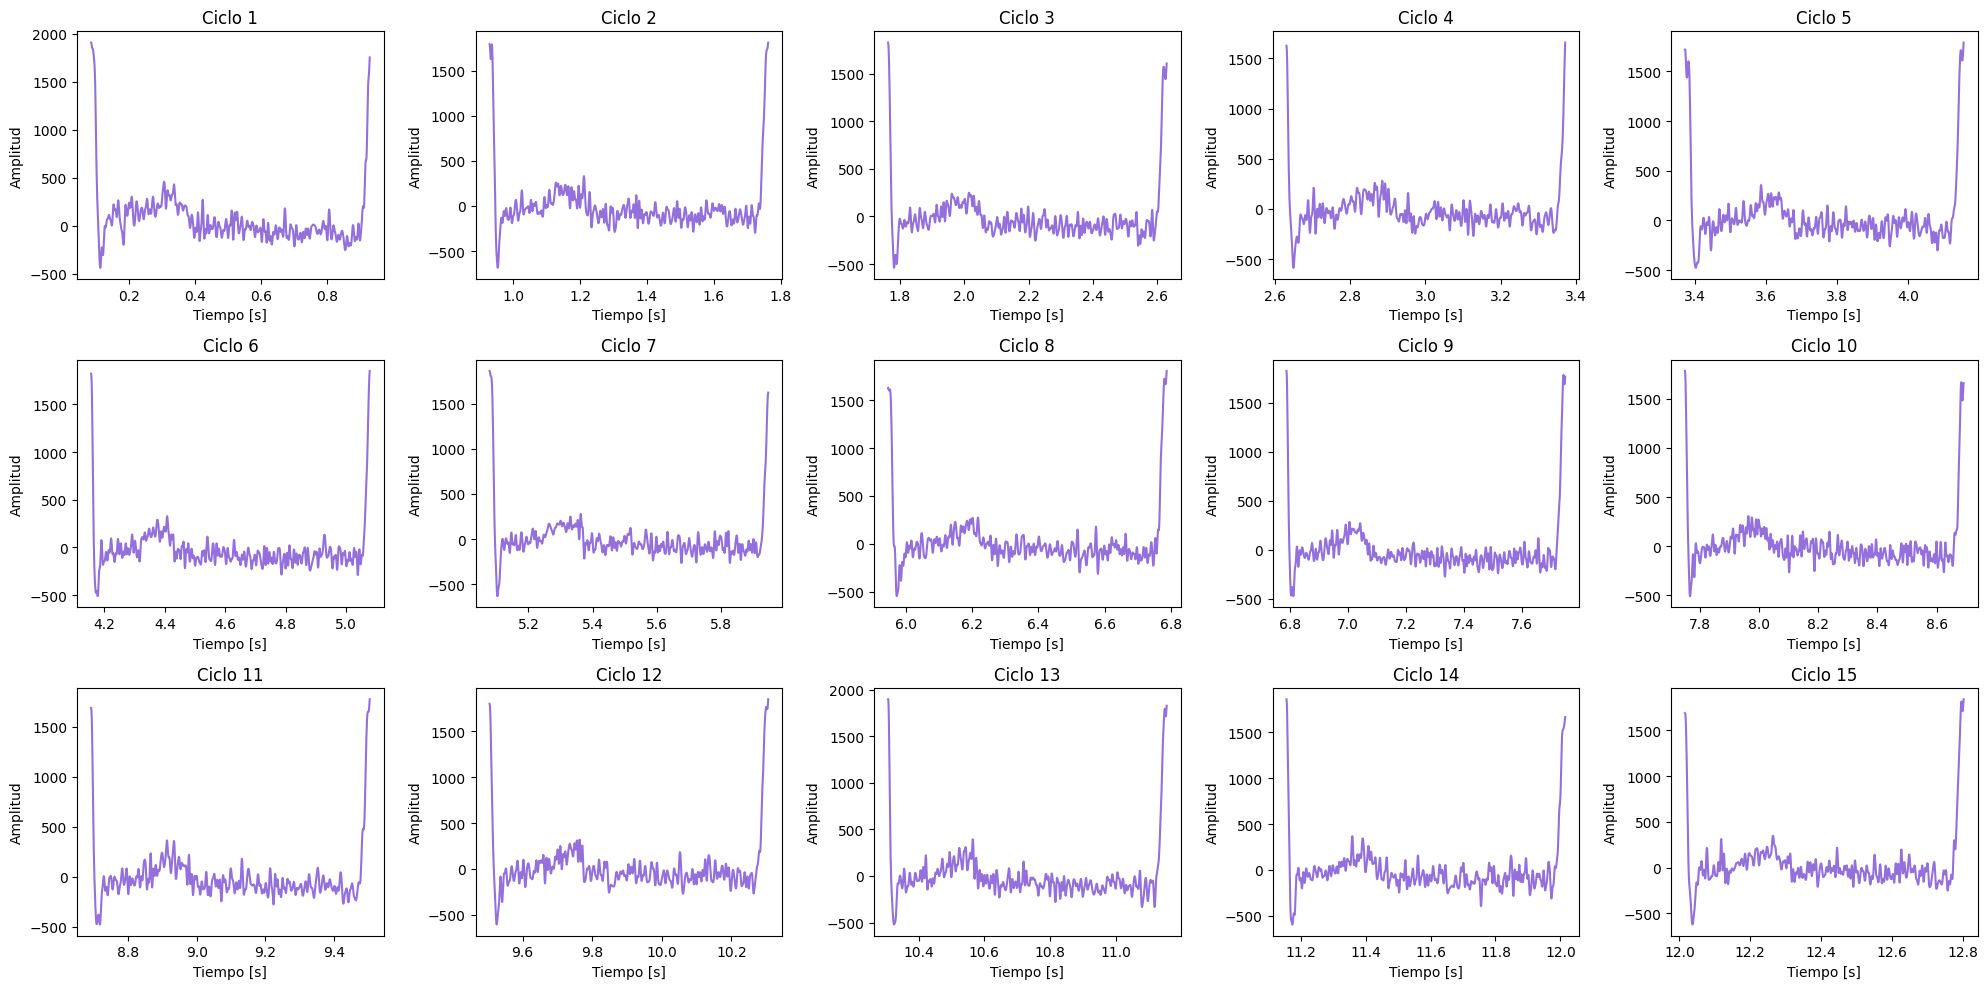

Ciclo 1: Promedio = 74.0100, Varianza = 96684.3149
Ciclo 2: Promedio = -1.4626, Varianza = 104790.4655
Ciclo 3: Promedio = -10.4330, Varianza = 82451.2511
Ciclo 4: Promedio = -20.9752, Varianza = 46839.0197
Ciclo 5: Promedio = 40.8711, Varianza = 114850.0201
Ciclo 6: Promedio = -27.9437, Varianza = 58147.5895
Ciclo 7: Promedio = 0.4308, Varianza = 77707.2812
Ciclo 8: Promedio = 21.4079, Varianza = 100268.1815
Ciclo 9: Promedio = -10.1753, Varianza = 71784.9558
Ciclo 10: Promedio = 8.8121, Varianza = 68481.0598
Ciclo 11: Promedio = -8.9062, Varianza = 76088.3849
Ciclo 12: Promedio = 13.2133, Varianza = 93862.6959
Ciclo 13: Promedio = -4.2033, Varianza = 87951.5045
Ciclo 14: Promedio = -14.9697, Varianza = 77022.1329
Ciclo 15: Promedio = 27.1083, Varianza = 89636.9356


In [37]:
# Extracción de 15 ciclos
ciclos = []
promedios = []
varianzas = []

fig, axs = plt.subplots(3, 5, figsize=(20, 10))  # 3 filas y 5 columnas

for i in range(15):
    ciclo_actual = ecg_filtrada[peaks[i]:peaks[i+1]]
    ciclos.append(ciclo_actual)
    promedio_ciclo = np.mean(ciclo_actual)
    promedios.append(promedio_ciclo)
    varianza_ciclo = np.var(ciclo_actual)
    varianzas.append(varianza_ciclo)

    t_ciclo = t[peaks[i]:peaks[i+1]]

    # Definir la posición en el subplot
    row = i // 5 # Cociente de la division
    col = i % 5 # Residuo de la division

    # Graficar el ciclo en la posición correspondiente
    axs[row, col].plot(t_ciclo, ciclo_actual, color='mediumpurple')
    axs[row, col].set_title(f'Ciclo {i+1}')
    axs[row, col].set_xlabel('Tiempo [s]')
    axs[row, col].set_ylabel('Amplitud')

# Ajustar la distribución del gráfico
plt.tight_layout()
plt.show()

# Mostrar los promedios y varianzas de cada ciclo
for i in range(15):
    print(f"Ciclo {i+1}: Promedio = {promedios[i]:.4f}, Varianza = {varianzas[i]:.4f}")


**Análisis grafico y estadistico**

**Análisis grafico:**

  * Los 15 ciclos gráficos muestran una estructura muy similar, sin embargo, las fluctuaciones entre los picos varían en amplitud y forma en cada ciclo.
  * Algunos ciclos tienen mayores oscilaciones, mientras que otros son más estables (con amplitudes más bajas).
  
  Estas diferencias visuales entre los ciclos sugiere que la señal no es constante.

**Análisis estadistico**

* Los promedios de los ciclos varían considerablemente. Van desde valores negativos hasta valores positivo. Estos cambios en el promedio indica que la señal no se mantiene estable a lo largo de todos los ciclos.

* La varianza, que mide la dispersión de los valores de cada ciclo, también muestra una alta variabilidad. Algunas varianzas son mucho mayores que otras, por ejemplo, el ciclo 2 tiene una varianza de 104790.47, mientras que el ciclo 6 tiene una varianza mucho menor de 58147.59. Esto sugiere que algunos ciclos tienen fluctuaciones mucho más extremas que otros, lo que contribuye a que la señal sea menos estable.

No se puede considerar que la señal es estacionaria debido a la variabilidad en las estadísticas de cada ciclo y la diferencia en el comportamiento gráfico entre ciclos. Tanto los gráficos como los valores del promedio y la varianza demuestran que la señal cambia con el tiempo, lo que es indicativo de una señal no estacionaria.

## Comparación entre el ciclo 2 y ciclo 5


**Normalidad:**

Prueba de Kolmogorov-Smirnov

**Hipótesis:**

p > alpha

*   H0: Los datos parecen normales (No se puede rechazar H0)
*   H1: Los datos no parecen normales (Se rechaza H0)



In [38]:
ciclo_dos = ciclos[1]
ciclo_cinco = ciclos[4]

ks_stats2, p_value2 = kstest(ciclo_dos, 'norm')
print('stat=%.3f, p=%.3f' % (ks_stats2, p_value2))

if p_value2 > 0.05:
  print('Los datos parecen normales (No se puede rechazar H0)')
else:
  print('Los datos no parecen normales (Se rechaza H0)')


stat=0.708, p=0.000
Los datos no parecen normales (Se rechaza H0)


In [39]:
ks_stats5, p_value5 = kstest(ciclo_cinco, 'norm')
print('stat=%.3f, p=%.3f' % (ks_stats5, p_value5))

if p_value5 > 0.05:
  print('Los datos parecen normales (No se puede rechazar H0)')
else:
  print('Los datos no parecen normales (Se rechaza H0)')

stat=0.587, p=0.000
Los datos no parecen normales (Se rechaza H0)


Para ambos ciclos, los datos no parecen seguir una distribución normal, ya que se rechazó la hipótesis nula (p = 0.000 para ambos ciclos). Esto implica que la prueba t de Student no es adecuada para comparar estas muestras, lo que justifica el uso de la prueba U de Mann-Whitney.

**Homocedasticidad:**

Prueba de Levene

**Hipótesis:**

*   H0: Los grupos tienen varianzas iguales
*   H1: Los grupos tienen varianzas diferentes



In [40]:
stat_levene, p_levene = levene(ciclo_dos, ciclo_cinco)
print('stat=%.3f, p=%.3f' % (stat_levene, p_levene))

if p_levene > 0.05:
  print('Los grupos tienen varianzas iguales (No se puede rechazar H0)')
else:
  print('Los grupos tienen varianzas diferentes (Se rechaza H0)')

stat=0.607, p=0.436
Los grupos tienen varianzas iguales (No se puede rechazar H0)


La prueba de Levene mostró que las varianzas entre los ciclos son iguales (p = 0.436). Aunque los datos no son normales, esta homogeneidad de varianza permite realizar comparaciones entre las muestras.

**Independencia**

Se asume que los grupos son independientes

**U Mann-Whitney-Wilcoxon**

* HO: No hay diferencia (en términos de tendencia central) entre los dos grupos de la población.
* H1: Existe una diferencia (con respecto a la tendencia central) entre los dos grupos de la población.

Las condiciones del u-test son:

* Los datos tienen que ser independientes.

* Los datos tienen que ser ordinales.

* No es necesario asumir que las muestras se distribuyen de forma normal.

* Igualdad de varianza entre grupos (homocedasticidad).

In [41]:
stat_mann, p_mann = mannwhitneyu(ciclo_dos, ciclo_cinco)
print('stat=%.3f, p=%.0f' % (stat_mann, p_mann))

if p_mann > 0.05:
  print('No se puede rechazar H0, no hay diferencias significativas entre los ciclos.')
else:
  print('Se rechaza H0, hay diferencias significativas entre los ciclos.')

stat=285265.000, p=0
Se rechaza H0, hay diferencias significativas entre los ciclos.


**Análisis ciclo 2 y 5**

El resultado de la prueba U de Mann-Whitney indica que los ciclos 2 y 5 tienen distribuciones diferentes [3]. Esto puede reflejar que las señales de ECG de ambos ciclos muestran características significativamente distintas, lo que podría deberse a variaciones fisiológicas entre los momentos en que fueron capturados los ciclos, o a diferencias en las condiciones bajo las cuales se realizó la medición (como actividad física, estado de reposo, entre otros factores).

## Comparación entre el ciclo 13 y ciclo 15

**Normalidad:**

Prueba de Kolmogorov-Smirnov

**Hipótesis:**

p > alpha

*   H0: Los datos parecen normales (No se puede rechazar H0)
*   H1: Los datos no parecen normales (Se rechaza H0)


In [42]:
ciclo_13 = ciclos[12]
ciclo_15 = ciclos[14]

ks_stats13, p_value13 = kstest(ciclo_13, 'norm')
print('stat=%.3f, p=%.3f' % (ks_stats13, p_value13))

if p_value13 > 0.05:
  print('Los datos parecen normales (No se puede rechazar H0)')
else:
  print('Los datos no parecen normales (Se rechaza H0)')

stat=0.704, p=0.000
Los datos no parecen normales (Se rechaza H0)


In [43]:
ks_stats15, p_value15 = kstest(ciclo_15, 'norm')
print('stat=%.3f, p=%.3f' % (ks_stats15, p_value15))

if p_value15 > 0.05:
  print('Los datos parecen normales (No se puede rechazar H0)')
else:
  print('Los datos no parecen normales (Se rechaza H0)')

stat=0.587, p=0.000
Los datos no parecen normales (Se rechaza H0)


Ambos ciclos no presentan normalidad, lo que significa que no se puede asumir una distribución normal de las señales de ECG para estos ciclos. Esto impide el uso de pruebas paramétricas tradicionales como la prueba t de Student, por lo que se deben emplear pruebas no paramétricas para realizar comparaciones entre estos ciclos.

**Homocedasticidad:**

Prueba de Levene

**Hipótesis:**

*   H0: Los grupos tienen varianzas iguales
*   H1: Los grupos tienen varianzas diferentes

In [44]:
stat_levene, p_levene = levene(ciclo_13, ciclo_15)
print('stat=%.3f, p=%.3f' % (stat_levene, p_levene))

if p_levene > 0.05:
  print('Los grupos tienen varianzas iguales (No se puede rechazar H0)')
else:
  print('Los grupos tienen varianzas diferentes (Se rechaza H0)')

stat=0.198, p=0.656
Los grupos tienen varianzas iguales (No se puede rechazar H0)


 A pesar de que los datos no son normales, la prueba de Levene confirma que ambos ciclos tienen varianzas similares. Esta homogeneidad en las varianzas permite realizar comparaciones válidas entre los dos grupos utilizando pruebas no paramétricas, como la prueba U de Mann-Whitney.

**Independencia**

Se asume que los grupos son independientes

**U Mann-Whitney-Wilcoxon**

* HO: No hay diferencia (en términos de tendencia central) entre los dos grupos de la población.
* H1: Existe una diferencia (con respecto a la tendencia central) entre los dos grupos de la población.

Las condiciones del u-test son:

* Los datos tienen que ser independientes.

* Los datos tienen que ser ordinales.

* No es necesario asumir que las muestras se distribuyen de forma normal.

* Igualdad de varianza entre grupos (homocedasticidad).


In [45]:
stat_mann, p_mann = mannwhitneyu(ciclo_13, ciclo_15)
print('stat=%.3f, p=%.0f' % (stat_mann, p_mann))

if p_mann > 0.05:
  print('No se puede rechazar H0, no hay diferencias significativas entre los ciclos.')
else:
  print('Se rechaza H0, hay diferencias significativas entre los ciclos.')

stat=293838.000, p=0
Se rechaza H0, hay diferencias significativas entre los ciclos.


La prueba U de Mann-Whitney muestra que existen diferencias significativas entre las distribuciones de los ciclos 13 y 15. Esto implica que las características de las señales de ECG de estos ciclos no son similares en términos de su tendencia central (la mediana). La diferencia puede reflejar cambios fisiológicos o de condiciones experimentales entre los dos momentos en que se tomaron las señales.

**Estacionariedad**

Prueba de Dickey-Fuller [5]

* HO: La serie temporal no es estacionaria, es decir, tiene una estructura que depende del tiempo y no presenta una varianza constante a lo largo del tiempo.

* H1: La serie temporal es estacionaria.

Estadístico ADF: Es el valor que indica qué tan lejos está la serie de ser estacionaria (valores más negativos indican estacionariedad).

Valores críticos: Estos son los valores del estadístico ADF que debes comparar para niveles de significancia del 1%, 5%, y 10%.

In [46]:
result = adfuller(ecg_filtrada)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[1] <= 0.05:
  print("La serie temporal es estacionaria.")
else:
  print("La serie temporal no es estacionaria.")

ADF Statistic: -0.654659
p-value: 0.858147
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
La serie temporal no es estacionaria.


La no estacionariedad de la señal ECG implica que sus propiedades estadísticas, como la media, la varianza y la correlación entre valores sucesivos, cambian a lo largo del tiempo. Esto puede ser un factor clave que influye en las diferencias observadas entre los ciclos del ECG, ya que las características de la señal varían conforme avanza el tiempo.

La falta de estacionariedad también puede afectar la interpretación de los resultados y la aplicación de métodos de análisis que asumen estabilidad en la señal. Las fluctuaciones observadas en los ciclos anteriores son coherentes con este resultado, ya que las propiedades de la señal parecen cambiar de un ciclo a otro, lo que refleja la naturaleza dinámica de las señales fisiológicas.

**Conclusiones**

 Las pruebas estadísticas, como la prueba U de Mann-Whitney, indican diferencias significativas entre los ciclos de ECG analizados, lo que sugiere que las características de las señales, como la amplitud y la forma de los picos, varían entre distintos ciclos. Esto podría deberse a fluctuaciones fisiológicas o cambios en las condiciones durante la toma de los datos.

La prueba de Dickey-Fuller confirmó que las señales de ECG no son estacionarias, lo que significa que sus propiedades cambian a lo largo del tiempo. Esta variabilidad temporal es un factor clave en la evaluación de señales fisiológicas y puede afectar la comparación entre ciclos.

El uso de un filtro pasa-bajo o pasa-banda fue crucial para eliminar componentes no deseadas en las señales de ECG, como el ruido y el desplazamiento de base. El filtrado permitió conservar las características importantes de la señal, como los picos de los latidos del corazón, mejorando la precisión del análisis.

El análisis estadistico permite evaluar cómo se comporta la señal en diferentes ciclos y bajo diferentes condiciones, destacando la importancia de este en la interpretación de datos biomédicos.

**Referencias**
* [1]	N.-T. Bui and G.-S. Byun, “The comparison features of ECG signal with different sampling frequencies and filter methods for real-time measurement,” Symmetry (Basel), vol. 13, no. 8, p. 1461, 2021.

* [2]	O. Guven, A. Eftekhar, W. Kindt, and T. G. Constandinou, “Low-power real-time ECG baseline wander removal: Hardware implementation,” in 2017 IEEE International Symposium on Circuits and Systems (ISCAS), 2017, vol. 101, pp. 1-4.
* [3]	“statistics — Funciones de estadística matemática — documentación de Python - 3.9.20,” Python.org. [Online]. Available: https://docs.python.org/es/3.9/library/statistics.html. [Accessed: 13-Sep-2024].

* [4]	“Prueba U de Mann-Whitney,” Datatab.es. [Online]. Available: https://datatab.es/tutorial/mann-whitney-u-test. [Accessed: 13-Sep-2024].

* [5]	“How to interpret adfuller test results?,” Stack Overflow. [Online]. Available: https://stackoverflow.com/questions/47349422/how-to-interpret-adfuller-test-results. [Accessed: 13-Sep-2024].
